# CIS419/519 Final Project - BERT Model

Downloading libraries

In [ ]:
%%capture
!pip install datasets
!pip install transformers
!pip install --upgrade accelerate
!pip install evaluate

In [ ]:
import pandas as pd
import zipfile
import os
from transformers import pipeline
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, DistilBertForSequenceClassification, DistilBertTokenizer
from datasets import load_dataset, Dataset
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
import torch
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device_id = 0 if str(device) == 'cuda' else -1
print(device_id)

0


Loading in data from preprocessing notebook

In [ ]:
# Path to the ZIP file
zip_path = '/content/all_tesla_data.zip'

# Dictionary to hold the DataFrames
dataframes = {}

# Open the ZIP file and read CSVs directly into DataFrames
with zipfile.ZipFile(zip_path, 'r') as zipf:
    # Iterate over each file in the ZIP archive
    for filename in zipf.namelist():
        if filename.endswith('.csv'):
            # Use ZipFile.open to read the file directly from the ZIP
            with zipf.open(filename) as file:
                # Create a DataFrame name by removing '.csv' and replacing characters if necessary
                df_name = filename.replace('.csv', '').replace('-', '_')
                # Read the CSV file into a DataFrame
                dataframes[df_name] = pd.read_csv(file)

print(dataframes.keys())

dict_keys(['train_data_w', 'test_data_w', 'train_data_m', 'test_data_m', 'train_data_q', 'test_data_q'])


#### Example BERT Model


In [ ]:
# Load BERTweet tokenizer and model
num_labels=2

tokenizer_bert = BertTokenizer.from_pretrained("vinai/bertweet-base")
#model_bert = BertForSequenceClassification.from_pretrained("bert-based-uncased", num_labels=num_labels)

tokenizer_dbert = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model_dbert = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=num_labels)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.txt:   0%|          | 0.00/843k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.91M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/558 [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BertweetTokenizer'. 
The class this function is called from is 'BertTokenizer'.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Function for tokenizing tweets for BERT

In [ ]:
def tokenize_function(tweets_df):
    # Tokenizing the body text and return the result
    return tokenizer(tweets_df['body'], max_length=128, padding='max_length', truncation=True)

Function for training BERT

In [ ]:
def train_model(model, epochs, train_dataloader, val_dataloader, device, lr_sched=True, initial_lr=5e-5, wd=0.0):
    optimizer = torch.optim.Adam(model.parameters(), lr=initial_lr, weight_decay=wd)
    avg_loss_per_epoch = []
    avg_accuracy_per_epoch = []
    avg_val_loss_per_epoch = []
    avg_val_accuracy_per_epoch = []

    # Optional Learning Rate Scheduler
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=1, verbose=True) if lr_sched else None

    for epoch_i in range(epochs):
        print(f'======== Epoch {epoch_i + 1} / {epochs} ========')
        print('Training...')

        # Training phase
        total_loss = 0
        total_train_accuracy = 0
        model.train()
        for batch in tqdm.tqdm(train_dataloader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['Target'].to(device)

            # Forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            # Calculate accuracy
            preds = torch.argmax(logits, dim=1)
            correct = torch.sum(preds == labels)
            total_train_accuracy += correct.item()

        # Average loss and accuracy for the training epoch
        avg_train_loss = total_loss / len(train_dataloader)
        avg_train_accuracy = 100 * (total_train_accuracy / len(train_dataloader.dataset))

        avg_loss_per_epoch.append(avg_train_loss)
        avg_accuracy_per_epoch.append(avg_train_accuracy)
        print(f"Average training loss: {avg_train_loss:.2f}")
        print(f"Average training accuracy: {avg_train_accuracy:.2f}%")

        # Validation phase
        total_val_loss = 0
        total_val_accuracy = 0
        model.eval()
        with torch.no_grad():
            for batch in tqdm.tqdm(val_dataloader):
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['Target'].to(device)

                outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                val_loss = outputs.loss
                logits = outputs.logits

                total_val_loss += val_loss.item()

                # Calculate accuracy
                preds = torch.argmax(logits, dim=1)
                correct = torch.sum(preds == labels)
                total_val_accuracy += correct.item()

        # Average loss and accuracy for the validation epoch
        avg_val_loss = total_val_loss / len(val_dataloader)
        avg_val_accuracy = 100 * (total_val_accuracy / len(val_dataloader.dataset))

        avg_val_loss_per_epoch.append(avg_val_loss)
        avg_val_accuracy_per_epoch.append(avg_val_accuracy)
        print(f"Average validation loss: {avg_val_loss:.2f}")
        print(f"Average validation accuracy: {avg_val_accuracy:.2f}%")

        # Adjusting the learning rate based on the validation loss
        if lr_sched:
            scheduler.step(avg_val_loss)

    return avg_loss_per_epoch, avg_accuracy_per_epoch, avg_val_loss_per_epoch, avg_val_accuracy_per_epoch

Function for evaluating BERT model predictions

In [ ]:
def evaluate_model(model, dataloader, device):
    model.eval()

    # Tracking variables
    total_eval_accuracy = 0
    predictions, true_labels = [], []

    # Predict
    for batch in tqdm.tqdm(dataloader):
        # Move batch data to the device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['Target'].to(device).long()

        # Forward pass, calculate logit predictions
        with torch.no_grad():
            output = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            logits = output.logits

        # Move logits and labels to CPU
        logits = logits.detach().cpu()
        labels = labels.to('cpu')

        # Calculate accuracy
        preds = torch.argmax(logits, dim=1)
        correct = torch.sum(preds == labels)
        total_eval_accuracy += correct.item()

        # Store predictions and true labels
        predictions.append(preds.numpy())
        true_labels.append(labels.numpy())

    # Report the final accuracy for this validation run
    avg_val_accuracy = 100 * (total_eval_accuracy / len(dataloader.dataset))
    print("\nAccuracy: {0:.2f}%".format(avg_val_accuracy))

    return avg_val_accuracy, predictions, true_labels

#### 1. Weekly Model

Defining training and testing dataframes as HuggingFace datasets


In [ ]:
train_dataset_w = Dataset.from_pandas(dataframes['train_data_w'])
test_dataset_w = Dataset.from_pandas(dataframes['test_data_w'])
print(f"Training examples: {len(train_dataset_w)}")

Training examples: 40000


Randomly sampling 20,000 tweets for training


In [ ]:
test_sample_w = test_dataset_w.shuffle(seed=42).select(range(10000))

train_dataset_w = train_dataset_w.shuffle(seed=42)
train_sample_w = train_dataset_w.select(range(30000))  # 30,000 for training
valid_sample_w = train_dataset_w.select(range(30000, 40000))  # 10,000 for validation

Tokenizing the tweets

In [ ]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
train_tokenized_w = train_sample_w.map(tokenize_function, batched=True)
val_tokenized_w = valid_sample_w.map(tokenize_function, batched=True)
test_tokenized_w = test_sample_w.map(tokenize_function, batched=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Map:   0%|          | 0/30000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Converting HuggingFace datasets to tensors for Pytorch

In [ ]:
# Also, we are dropping the 'Body' and 'Date' columns here since they are not needed anymore
train_tokenized_w.set_format(type='torch', columns=['input_ids', 'attention_mask', 'Target'])
val_tokenized_w.set_format(type='torch', columns=['input_ids', 'attention_mask', 'Target'])
test_tokenized_w.set_format(type='torch', columns=['input_ids', 'attention_mask', 'Target'])

Checking to make sure the number of labels is still correct

In [ ]:
labels_tensor = train_tokenized_w['Target']
labels_list = labels_tensor.tolist()
unique_labels = set(labels_list)
num_unique_labels = len(unique_labels)

print("Number of unique labels:", num_unique_labels)
print("Unique Labels:", unique_labels)

Number of unique labels: 2
Unique Labels: {0, 1}


Converting training and testing datasets into dataloaders

In [ ]:
batch_size = 32
train_dataloader_w = DataLoader(train_tokenized_w, batch_size=batch_size, shuffle=True)
val_dataloader_w = DataLoader(val_tokenized_w, batch_size=batch_size, shuffle=True)
test_dataloader_w = DataLoader(test_tokenized_w, batch_size=batch_size, shuffle=True)

Moving model to the GPU

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_w = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)
model_w = model_w.to(device)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Running training function

In [ ]:
# Running training function for 5 epochs
avg_loss_w, avg_acc_w, avg_val_loss_w, avg_val_acc_w = train_model(model=model_w,
                                                                   epochs=5,
                                                                   train_dataloader=train_dataloader_w,
                                                                   val_dataloader=val_dataloader_w,
                                                                   device=device
                                                                   )

======== Epoch 1 / 5 ========
Training...


100%|██████████| 938/938 [05:01<00:00,  3.11it/s]


Average training loss: 0.69
Average training accuracy: 50.30%


100%|██████████| 313/313 [00:35<00:00,  8.82it/s]


Average validation loss: 0.69
Average validation accuracy: 49.84%
======== Epoch 2 / 5 ========
Training...


100%|██████████| 938/938 [05:01<00:00,  3.11it/s]


Average training loss: 0.69
Average training accuracy: 50.77%


100%|██████████| 313/313 [00:34<00:00,  9.09it/s]


Average validation loss: 0.69
Average validation accuracy: 50.57%
======== Epoch 3 / 5 ========
Training...


100%|██████████| 938/938 [05:01<00:00,  3.11it/s]


Average training loss: 0.69
Average training accuracy: 50.88%


100%|██████████| 313/313 [00:35<00:00,  8.85it/s]


Average validation loss: 0.69
Average validation accuracy: 51.70%
======== Epoch 4 / 5 ========
Training...


100%|██████████| 938/938 [05:02<00:00,  3.11it/s]


Average training loss: 0.69
Average training accuracy: 54.99%


100%|██████████| 313/313 [00:34<00:00,  9.01it/s]


Average validation loss: 0.69
Average validation accuracy: 50.49%
======== Epoch 5 / 5 ========
Training...


100%|██████████| 938/938 [05:01<00:00,  3.11it/s]


Average training loss: 0.65
Average training accuracy: 62.39%


100%|██████████| 313/313 [00:35<00:00,  8.87it/s]

Average validation loss: 0.72
Average validation accuracy: 53.01%


Plotting

In [ ]:
def plot_training_results(avg_loss_per_epoch, avg_accuracy_per_epoch, avg_val_loss_per_epoch, avg_val_accuracy_per_epoch):
    epochs = range(1, len(avg_loss_per_epoch) + 1)

    plt.figure(figsize=(12, 5))

    # Plotting training and validation loss on the same plot
    plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
    plt.plot(epochs, avg_loss_per_epoch, label='Training Loss', marker='o', color='blue')
    plt.plot(epochs, avg_val_loss_per_epoch, label='Validation Loss', marker='o', linestyle='--', color='green')
    plt.title('Training & Validation Loss Per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()

    # Plotting training and validation accuracy on the same plot
    plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
    plt.plot(epochs, avg_accuracy_per_epoch, label='Training Accuracy', color='red', marker='o')
    plt.plot(epochs, avg_val_accuracy_per_epoch, label='Validation Accuracy', color='purple', marker='o', linestyle='--')
    plt.title('Training & Validation Accuracy Per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

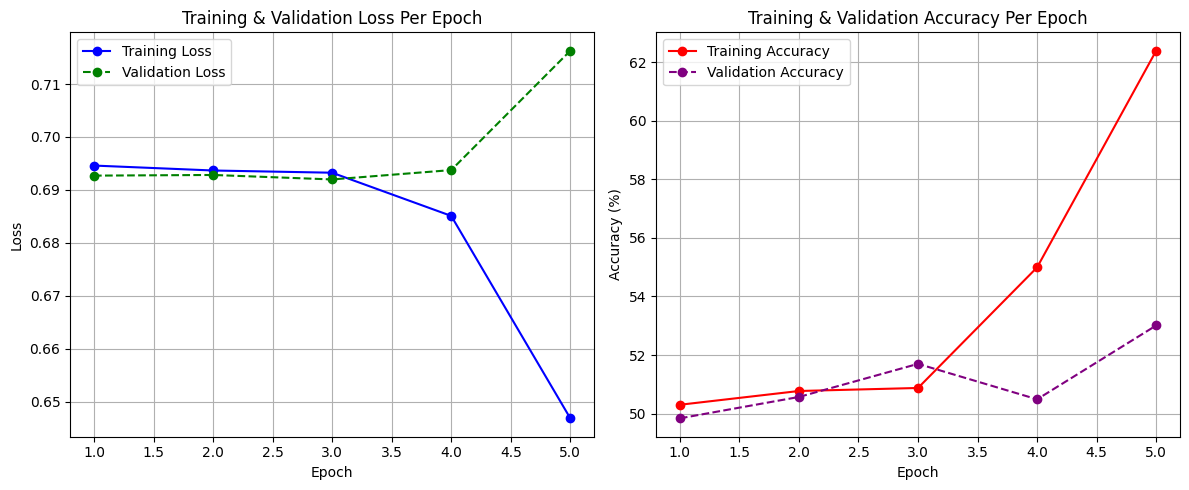

In [ ]:
plot_training_results(avg_loss_w, avg_acc_w, avg_val_loss_w, avg_val_acc_w)

Evaluating weekly model

In [ ]:
avg_test_acc_w, preds_w, labels_w = evaluate_model(model=model_w, dataloader=test_dataloader_w, device=device)

100%|██████████| 313/313 [00:33<00:00,  9.23it/s]


Accuracy: 49.83%


Printing evaluation results

In [ ]:
# Combine the results across all batches
if isinstance(preds_w[0], torch.Tensor):
    preds_w_cpu = np.concatenate([batch.cpu().numpy() for batch in preds_w], axis=0)
    labels_w_cpu = np.concatenate([batch.cpu().numpy() for batch in labels_w], axis=0)
else:  # If they are numpy arrays already
    preds_w_cpu = np.concatenate(preds_w, axis=0)
    labels_w_cpu = np.concatenate(labels_w, axis=0)

# Used sklearn to calculate the recall, F1, and confusion matrix per class
classification_rep = classification_report(labels_w_cpu, preds_w_cpu)
conf_matrix = confusion_matrix(labels_w_cpu, preds_w_cpu)

print("Classification Report:")
print(classification_rep)

print("Confusion Matrix:")
print(conf_matrix)

Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.70      0.58      5000
           1       0.50      0.29      0.37      5000

    accuracy                           0.50     10000
   macro avg       0.50      0.50      0.48     10000
weighted avg       0.50      0.50      0.48     10000

Confusion Matrix:
[[3510 1490]
 [3527 1473]]


Evaluating the weekly model on current tweets (from May 2024)

In [ ]:
curr_tweets_df = pd.DataFrame(pd.read_csv('/content/curr_tweets'))
curr_tweets_df.head()

,body,Target
0,well washing your tesla cybertruck in a drive ...,0.0
1,do you all have a system for the model 3 premi...,0.0
2,yup will drop tesla eps to near zero powerwall...,0.0
3,is paying now for decision in 2019 tesla secre...,0.0
4,as a proud german tesla investor and happy mod...,0.0


In [ ]:
# First, we must tokenize these tweets from this past week in order to pass them into the BERT model
curr_tweets_dataset = Dataset.from_pandas(curr_tweets_df)
curr_tweets_tokenized = curr_tweets_dataset.map(tokenize_function, batched=True)
curr_tweets_tokenized.set_format(type='torch', columns=['input_ids', 'attention_mask', 'Target'])
curr_test_dataloader = DataLoader(curr_tweets_tokenized, batch_size=batch_size, shuffle=True)

avg_curr_test_acc_w, curr_preds_w, curr_labels_w = evaluate_model(model=model_w, dataloader=curr_test_dataloader, device=device)

Map:   0%|          | 0/7579 [00:00<?, ? examples/s]

100%|██████████| 237/237 [00:24<00:00,  9.62it/s]


Accuracy: 52.71%


#### Monthly Model

In [ ]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Defining training and testing dataframes as HuggingFace datasets
train_dataset_m = Dataset.from_pandas(dataframes['train_data_m'])
test_dataset_m = Dataset.from_pandas(dataframes['test_data_m'])

# Randomly sampling 40,000 tweets for training
train_dataset_m = train_dataset_m.shuffle(seed=42)
train_sample_m = train_dataset_m.select(range(30000))  # 30,000 for training
valid_sample_m = train_dataset_m.select(range(30000, 40000))  # 10,000 for validation
test_sample_m = test_dataset_m.shuffle(seed=42).select(range(10000))

# Tokenizing the tweets
train_tokenized_m = train_sample_m.map(tokenize_function, batched=True)
val_tokenized_m = valid_sample_m.map(tokenize_function, batched=True)
test_tokenized_m = test_sample_m.map(tokenize_function, batched=True)

# Defining tensors
train_tokenized_m.set_format(type='torch', columns=['input_ids', 'attention_mask', 'Target'])
val_tokenized_m.set_format(type='torch', columns=['input_ids', 'attention_mask', 'Target'])
test_tokenized_m.set_format(type='torch', columns=['input_ids', 'attention_mask', 'Target'])

# Dataloaders
batch_size = 32
train_dataloader_m = DataLoader(train_tokenized_m, batch_size=batch_size, shuffle=True)
val_dataloader_m = DataLoader(val_tokenized_m, batch_size=batch_size, shuffle=True)
test_dataloader_m = DataLoader(test_tokenized_m, batch_size=batch_size, shuffle=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Map:   0%|          | 0/30000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Running training for monthly labeling model

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_m = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)
model_m = model_m.to(device)

# Running training function for 10 epochs
avg_loss_m, avg_acc_m, avg_val_loss_m, avg_val_acc_m = train_model(model=model_m,
                                                                   epochs=5,
                                                                   train_dataloader=train_dataloader_m,
                                                                   val_dataloader=val_dataloader_m,
                                                                   device=device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


======== Epoch 1 / 5 ========
Training...


100%|██████████| 938/938 [05:02<00:00,  3.10it/s]


Average training loss: 0.69
Average training accuracy: 50.53%


100%|██████████| 313/313 [00:35<00:00,  8.92it/s]


Average validation loss: 0.69
Average validation accuracy: 52.34%
======== Epoch 2 / 5 ========
Training...


100%|██████████| 938/938 [05:02<00:00,  3.10it/s]


Average training loss: 0.69
Average training accuracy: 52.92%


100%|██████████| 313/313 [00:35<00:00,  8.90it/s]


Average validation loss: 0.69
Average validation accuracy: 54.88%
======== Epoch 3 / 5 ========
Training...


100%|██████████| 938/938 [05:01<00:00,  3.11it/s]


Average training loss: 0.66
Average training accuracy: 60.37%


100%|██████████| 313/313 [00:34<00:00,  9.00it/s]


Average validation loss: 0.70
Average validation accuracy: 53.81%
======== Epoch 4 / 5 ========
Training...


100%|██████████| 938/938 [05:01<00:00,  3.11it/s]


Average training loss: 0.59
Average training accuracy: 69.27%


100%|██████████| 313/313 [00:35<00:00,  8.94it/s]


Average validation loss: 0.74
Average validation accuracy: 55.87%
======== Epoch 5 / 5 ========
Training...


100%|██████████| 938/938 [05:01<00:00,  3.11it/s]


Average training loss: 0.44
Average training accuracy: 80.08%


100%|██████████| 313/313 [00:35<00:00,  8.93it/s]

Average validation loss: 0.86
Average validation accuracy: 56.19%


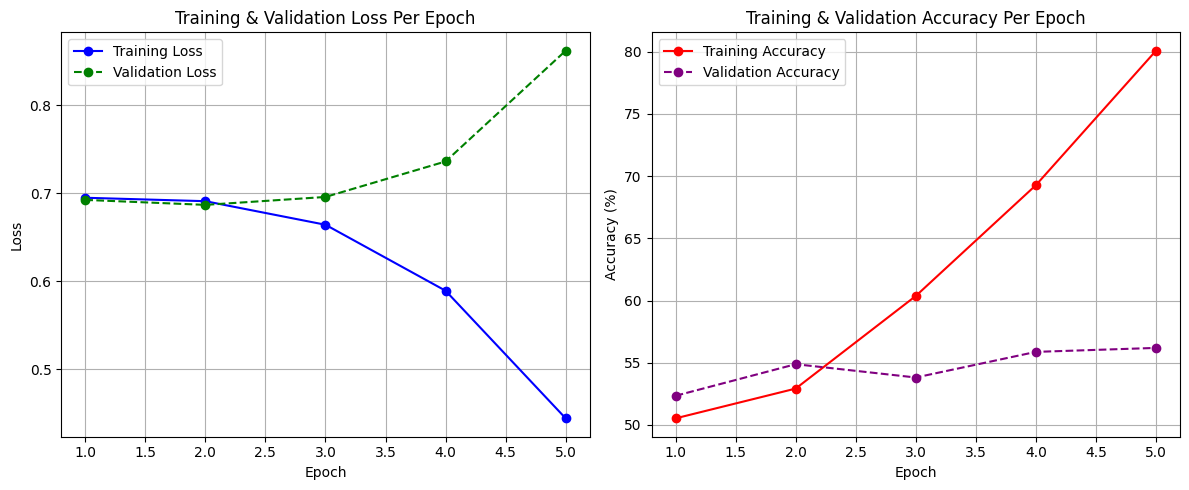

In [ ]:
plot_training_results(avg_loss_m, avg_acc_m, avg_val_loss_m, avg_val_acc_m)

In [ ]:
avg_test_acc_m, preds_m, labels_m = evaluate_model(model=model_m, dataloader=test_dataloader_m, device=device)

100%|██████████| 313/313 [00:33<00:00,  9.35it/s]


Accuracy: 48.61%


Printing evaluation results

In [ ]:
preds_m_cpu = np.concatenate(preds_m, axis=0)
labels_m_cpu = np.concatenate(labels_m, axis=0)

classification_rep = classification_report(labels_m_cpu, preds_m_cpu)
conf_matrix = confusion_matrix(labels_m_cpu, preds_m_cpu)

print("Classification Report:")
print(classification_rep)

print("Confusion Matrix:")
print(conf_matrix)

Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.37      0.42      5000
           1       0.49      0.60      0.54      5000

    accuracy                           0.49     10000
   macro avg       0.49      0.49      0.48     10000
weighted avg       0.49      0.49      0.48     10000

Confusion Matrix:
[[1858 3142]
 [1997 3003]]


Evaluating the monthly model on current tweets (May 2024)

In [ ]:
avg_curr_test_acc_m, curr_preds_m, curr_labels_m = evaluate_model(model=model_m, dataloader=curr_test_dataloader, device=device)

100%|██████████| 237/237 [00:25<00:00,  9.23it/s]


Accuracy: 47.90%


#### Quarterly Model

In [ ]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Assuming 'balanced_train_datasets' and 'dataframes' are predefined and contain the dataframes
train_dataset_q = Dataset.from_pandas(dataframes['train_data_q'])
test_dataset_q = Dataset.from_pandas(dataframes['test_data_q'])

# Shuffle and split the training dataset into training and validation
train_dataset_q = train_dataset_q.shuffle(seed=42)
train_sample_q = train_dataset_q.select(range(30000))  # 30,000 for training
valid_sample_q = train_dataset_q.select(range(30000, 40000))  # 10,000 for validation

# Shuffle and select the test dataset
test_sample_q = test_dataset_q.shuffle(seed=42).select(range(10000))

# Tokenizing the tweets
train_tokenized_q = train_sample_m.map(tokenize_function, batched=True)
valid_tokenized_q = valid_sample_q.map(tokenize_function, batched=True)
test_tokenized_q = test_sample_m.map(tokenize_function, batched=True)

# Defining tensors
train_tokenized_q.set_format(type='torch', columns=['input_ids', 'attention_mask', 'Target'])
valid_tokenized_q.set_format(type='torch', columns=['input_ids', 'attention_mask', 'Target'])
test_tokenized_q.set_format(type='torch', columns=['input_ids', 'attention_mask', 'Target'])

# Dataloaders
batch_size = 32
train_dataloader_q = DataLoader(train_tokenized_q, batch_size=batch_size, shuffle=True)
valid_dataloader_q = DataLoader(valid_tokenized_q, batch_size=batch_size, shuffle=True)
test_dataloader_q = DataLoader(test_tokenized_q, batch_size=batch_size, shuffle=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Map:   0%|          | 0/30000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Running training for quarterly labeling model

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#model_m = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
model_q = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)
model_q = model_q.to(device)

# Running training function for 10 epochs
avg_loss_q, avg_acc_q, avg_val_loss_q, avg_val_acc_q = train_model(model=model_q,
                                                                   epochs=5,
                                                                   train_dataloader=train_dataloader_q,
                                                                   val_dataloader=valid_dataloader_q,
                                                                   device=device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


======== Epoch 1 / 5 ========
Training...


100%|██████████| 938/938 [05:01<00:00,  3.11it/s]


Average training loss: 0.69
Average training accuracy: 50.62%


100%|██████████| 313/313 [00:35<00:00,  8.86it/s]


Average validation loss: 0.70
Average validation accuracy: 49.76%
======== Epoch 2 / 5 ========
Training...


100%|██████████| 938/938 [05:01<00:00,  3.11it/s]


Average training loss: 0.69
Average training accuracy: 52.48%


100%|██████████| 313/313 [00:34<00:00,  9.00it/s]


Average validation loss: 0.70
Average validation accuracy: 50.18%
======== Epoch 3 / 5 ========
Training...


100%|██████████| 938/938 [05:00<00:00,  3.12it/s]


Average training loss: 0.68
Average training accuracy: 57.42%


100%|██████████| 313/313 [00:34<00:00,  9.01it/s]


Average validation loss: 0.71
Average validation accuracy: 49.15%
======== Epoch 4 / 5 ========
Training...


100%|██████████| 938/938 [05:00<00:00,  3.12it/s]


Average training loss: 0.63
Average training accuracy: 64.68%


100%|██████████| 313/313 [00:34<00:00,  9.00it/s]


Average validation loss: 0.78
Average validation accuracy: 48.74%
======== Epoch 5 / 5 ========
Training...


100%|██████████| 938/938 [05:00<00:00,  3.12it/s]


Average training loss: 0.55
Average training accuracy: 72.96%


100%|██████████| 313/313 [00:34<00:00,  9.00it/s]

Average validation loss: 0.89
Average validation accuracy: 48.76%


Plotting training results

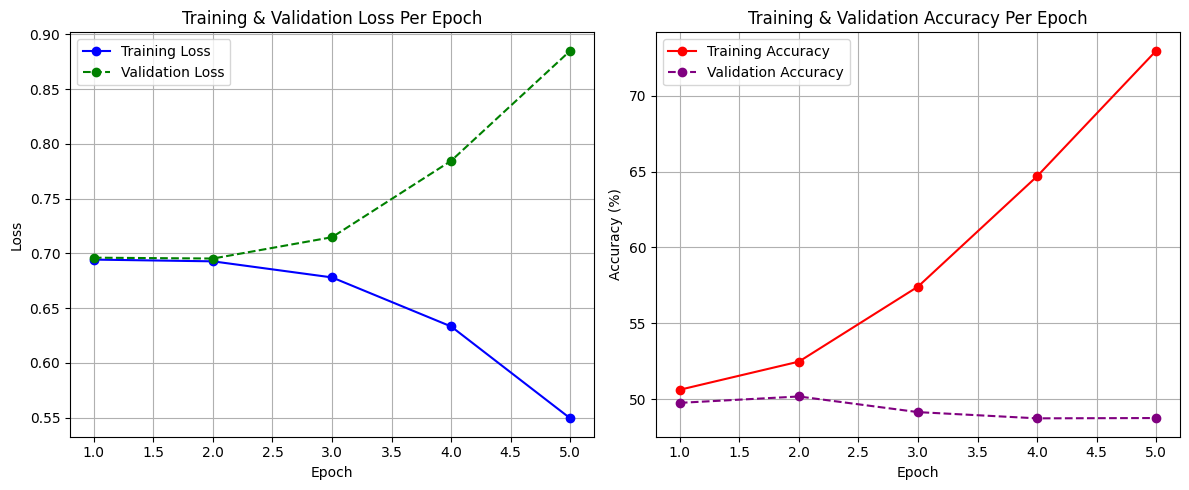

In [ ]:
plot_training_results(avg_loss_q, avg_acc_q, avg_val_loss_q, avg_val_acc_q)

Evaluating quarterly model

In [ ]:
avg_test_acc_q, preds_q, labels_q = evaluate_model(model=model_q, dataloader=test_dataloader_q, device=device)

100%|██████████| 313/313 [00:35<00:00,  8.73it/s]


Accuracy: 48.98%


Prining evaluation results

In [ ]:
preds_q_cpu = np.concatenate(preds_q, axis=0)
labels_q_cpu = np.concatenate(labels_q, axis=0)

classification_rep = classification_report(labels_q_cpu, preds_q_cpu)
conf_matrix = confusion_matrix(labels_q_cpu, preds_q_cpu)

print("Classification Report:")
print(classification_rep)

print("Confusion Matrix:")
print(conf_matrix)

Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.40      0.44      5000
           1       0.49      0.58      0.53      5000

    accuracy                           0.49     10000
   macro avg       0.49      0.49      0.49     10000
weighted avg       0.49      0.49      0.49     10000

Confusion Matrix:
[[2020 2980]
 [2122 2878]]


In [ ]:
avg_curr_test_acc_q, curr_preds_q, curr_labels_q = evaluate_model(model=model_q, dataloader=curr_test_dataloader, device=device)

100%|██████████| 237/237 [00:26<00:00,  8.83it/s]


Accuracy: 48.73%
